For run 20.

1. Optimization results
2. Starting positions from run 19

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import pickle
from scipy import stats

In [2]:
from generate_opt_objects import A_b_generation

**PNC:/Users/mikestanley/miniconda3/envs/carbonflux_39/lib/python3.9/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  pyproj could not be found, so IO/API coordinates cannot be converted to lat/lon; to fix, install pyproj or basemap (e.g., `pip install pyproj)`


In [3]:
# import matplotlib

# # matplotlib settings
# matplotlib.rcParams['text.usetex'] = True
# plt.rcParams.update({'font.size': 18})
# plt.rc('text.latex', preamble=r'\usepackage{bm}')

In [4]:
# results base directory
BASE_DIR = './data/carbon_flux/results'

# save filepath
SAVE_FIG_BASE = '../figures/interval_optimizations/northern_hemisphere_jun2010/dual/20'

# plotting directory
IMAGE_PATH = '/Users/mikestanley/Research/Carbon_Flux/optimization/figures/final_images'

In [5]:
# paths
OBS_FP = '../fixed_optimization_inputs/y_affine_corrected.npy'

In [6]:
# get necessary objects
with open(OBS_FP, 'rb') as f:
    y_obs = np.load(f)
    
# gosat data
with open('../fixed_optimization_inputs/gosat_df_jan1_aug31_2010.csv', 'rb') as f:
    gosat_df = pd.read_csv(f)
L_inv_vec = 1 / gosat_df.xco2_unc.values
    
# tranform the data
y_tilde = np.multiply(L_inv_vec, y_obs)

CONSTR_DIR = '/Users/mikestanley/Research/Carbon_Flux/optimization/data/sign_corrected'
A, b = A_b_generation(
    box_constraint_fp=CONSTR_DIR + '/scipy_bnds.pkl'
)

FUNC_BASE = '/Users/mikestanley/Research/Carbon_Flux/optimization'
FUNC_FP = FUNC_BASE + '/src_admm/data/carbon_flux/objects/nh_june_functional.npy'
FUNC_NO_CONTR_FP = FUNC_BASE + '/src_admm/data/carbon_flux/objects/nh_june_functional_no_control.npy'
with open(FUNC_FP, 'rb') as f:
    h = np.load(f)
with open(FUNC_NO_CONTR_FP, 'rb') as f:
    h_no_contr = np.load(f)

In [7]:
# psi_alpha
with open('./data/carbon_flux/objects/opt_res_cont.pkl', 'rb') as f:
    opt_slack = pickle.load(f)
    
PSI_ALPHA = np.sqrt(stats.chi2.ppf(q=.95, df=1) + opt_slack[1])

In [8]:
# true functional value
# read in the jules fluxes
with open('/Users/mikestanley/Research/Carbon_Flux/optimization/data/jules_month_avg.npy', 'rb') as f:
    jules_month_flux = np.load(f)
print(jules_month_flux.shape)

true_func_val = np.dot(
    np.swapaxes(jules_month_flux[:8, :, :], axis1=1, axis2=2).flatten(),
    h_no_contr
)

print('True functional value: %s' % str(true_func_val))

(12, 72, 46)
True functional value: -0.2986273507282801


# Plotting Functions

In [9]:
def global_avg_plot(w_ser, title_str=None, figsize=(8, 5)):
    """
    Globally averaged weights at daily, weekly, and month res
    
    Parameters
    ----------
        w_ser (pandas series) : weights indexed by time
    """
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize)
    ts_day = w_ser.resample('D').mean()
    ts_week = w_ser.resample('W').mean()
    ts_month = w_ser.resample('M').mean()
    ts_day.plot(ax=ax, label='Day')
    ts_week.plot(ax=ax, label='Week')
    ts_month.plot(ax=ax, label='Month')
    ax.axhline(0, linestyle='--', color='gray')
    ax.legend()
    ax.set_title(title_str)
    plt.show()
    
def month_map_plot(df, w_col_str, norm, vmin=None, vmax=None, figsize=(12, 16), save_fp=None):
    """
    Monthly heat maps for the given weights
    
    Parameters
    ----------
        df        (pandas dataframe)  : contains columns - 'month', 'lon', 'lat', and w_col_str
        w_col_str (str)               : name of w column in df to use
        norm      (mcolors.Normalize) : for color scheme
    """
    # w start
    fig, ax = plt.subplots(ncols=2, nrows=4, figsize=figsize)
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

    for i in range(8):
        row_idx = i // 2
        col_idx = i % 2
        month_idxs = df['month'].astype(int) == i + 1
        sp_i = ax[row_idx, col_idx].scatter(
            df['lon'][month_idxs], df['lat'][month_idxs],
            c=df[w_col_str][month_idxs],
            norm=norm, vmin=vmin, vmax=vmax,
            s=14, cmap='seismic'
        )
        ax[row_idx, col_idx].set_title(months[i])

    plt.colorbar(sp_i,ax=ax[0, 0])
    if save_fp:
        plt.savefig(save_fp, dpi=300)
        plt.close()
    else:
        plt.show()

# Optimization Diagnostics

#### Convergence Plots

In [10]:
BASE_DIR

'./data/carbon_flux/results'

In [11]:
# read in the raw stdout file
# with open(BASE_DIR + '/20/stdout_0_2.txt', 'r') as f:
with open(BASE_DIR + '/20/stdout.txt', 'r') as f:
    stdout_0_2_raw = f.readlines()
    
with open(BASE_DIR + '/20/stdout_3_10.txt', 'r') as f:
    stdout_3_10_raw = f.readlines()

In [12]:
# isolate the trajectories from the w optimization
all_obj_vals_0_2 = [float(line[22:34].replace('D', 'e')) for line in stdout_0_2_raw if 'At iterate' in line]
all_obj_vals_3_10 = [float(line[22:34].replace('D', 'e')) for line in stdout_3_10_raw if 'At iterate' in line]

all_obj_vals = all_obj_vals_0_2 + all_obj_vals_3_10

traj_w_01 = all_obj_vals[:13]
traj_c_01 = all_obj_vals[13:16]
traj_w_02 = all_obj_vals[16:29]
traj_c_02 = all_obj_vals[29:32]
traj_w_03 = all_obj_vals[32:45]
traj_c_03 = all_obj_vals[45:48]
traj_w_04 = all_obj_vals[48:61]
traj_c_04 = all_obj_vals[61:64]
traj_w_05 = all_obj_vals[64:77]
traj_c_05 = all_obj_vals[77:80]
traj_w_06 = all_obj_vals[80:]
# traj_c_06 = all_obj_vals[93:96]
# traj_w_07 = all_obj_vals[96:109]
# traj_c_07 = all_obj_vals[109:112]
# traj_w_08 = all_obj_vals[112:125]
# traj_c_08 = all_obj_vals[125:128]
# traj_w_09 = all_obj_vals[128:]
# traj_c_09 = all_obj_vals[141:144]
# traj_w_10 = all_obj_vals[144:157]
# traj_c_10 = all_obj_vals[157:]

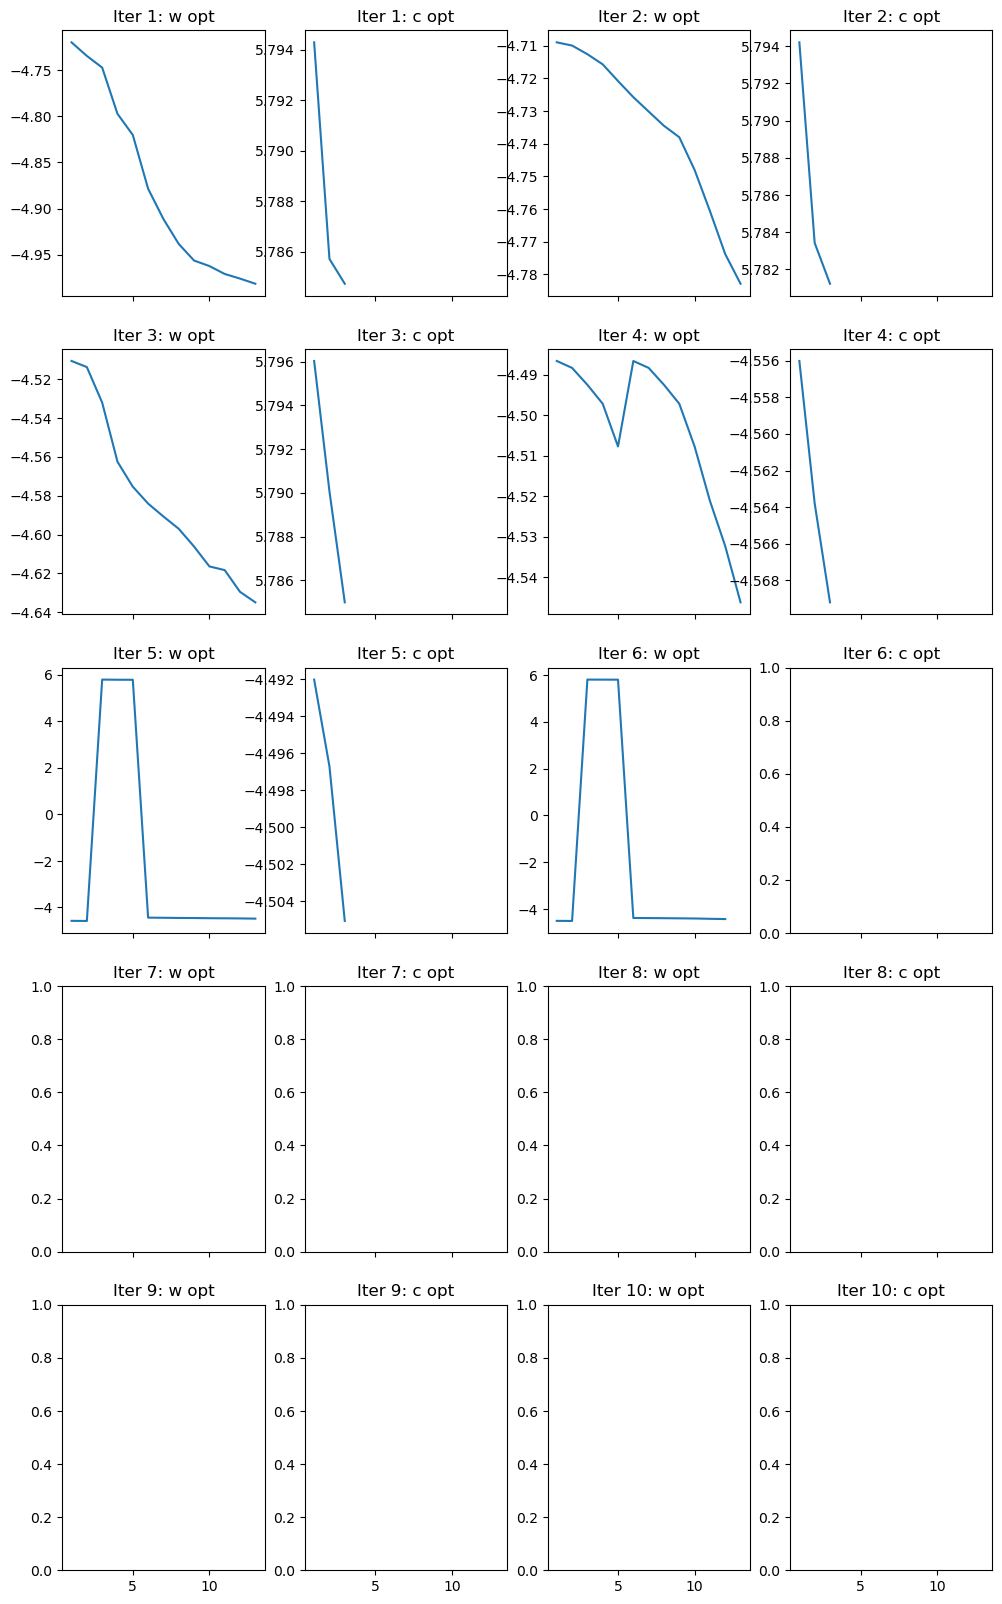

In [14]:
fig, ax = plt.subplots(ncols=4, nrows=5, figsize=(12, 20), sharex=True)

# iteration 1
ax[0, 0].plot(np.arange(1, len(traj_w_01) + 1), traj_w_01)
ax[0, 1].plot(np.arange(1, len(traj_c_01) + 1), traj_c_01)

# iteration 2
ax[0, 2].plot(np.arange(1, len(traj_w_02) + 1), traj_w_02)
ax[0, 3].plot(np.arange(1, len(traj_c_02) + 1), traj_c_02)

# iteration 3
ax[1, 0].plot(np.arange(1, len(traj_w_03) + 1), traj_w_03)
ax[1, 1].plot(np.arange(1, len(traj_c_03) + 1), traj_c_03)

# iteration 4
ax[1, 2].plot(np.arange(1, len(traj_w_04) + 1), traj_w_04)
ax[1, 3].plot(np.arange(1, len(traj_c_04) + 1), traj_c_04)

# iteration 5
ax[2, 0].plot(np.arange(1, len(traj_w_05) + 1), traj_w_05)
ax[2, 1].plot(np.arange(1, len(traj_c_05) + 1), traj_c_05)

# iteration 6
ax[2, 2].plot(np.arange(1, len(traj_w_06) + 1), traj_w_06)
# ax[2, 3].plot(np.arange(1, len(traj_c_06) + 1), traj_c_06)

# # iteration 7
# ax[3, 0].plot(np.arange(1, len(traj_w_07) + 1), traj_w_07)
# ax[3, 1].plot(np.arange(1, len(traj_c_07) + 1), traj_c_07)

# # iteration 8
# ax[3, 2].plot(np.arange(1, len(traj_w_08) + 1), traj_w_08)
# ax[3, 3].plot(np.arange(1, len(traj_c_08) + 1), traj_c_08)

# # iteration 9
# ax[4, 0].plot(np.arange(1, len(traj_w_09) + 1), traj_w_09)
# ax[4, 1].plot(np.arange(1, len(traj_c_09) + 1), traj_c_09)

# # iteration 10
# ax[4, 2].plot(np.arange(1, len(traj_w_10) + 1), traj_w_10)
# ax[4, 3].plot(np.arange(1, len(traj_c_10) + 1), traj_c_10)

# labels
ax[0, 0].set_title('Iter 1: w opt')
ax[0, 1].set_title('Iter 1: c opt')
ax[0, 2].set_title('Iter 2: w opt')
ax[0, 3].set_title('Iter 2: c opt')
ax[1, 0].set_title('Iter 3: w opt')
ax[1, 1].set_title('Iter 3: c opt')
ax[1, 2].set_title('Iter 4: w opt')
ax[1, 3].set_title('Iter 4: c opt')
ax[2, 0].set_title('Iter 5: w opt')
ax[2, 1].set_title('Iter 5: c opt')
ax[2, 2].set_title('Iter 6: w opt')
ax[2, 3].set_title('Iter 6: c opt')
ax[3, 0].set_title('Iter 7: w opt')
ax[3, 1].set_title('Iter 7: c opt')
ax[3, 2].set_title('Iter 8: w opt')
ax[3, 3].set_title('Iter 8: c opt')
ax[4, 0].set_title('Iter 9: w opt')
ax[4, 1].set_title('Iter 9: c opt')
ax[4, 2].set_title('Iter 10: w opt')
ax[4, 3].set_title('Iter 10: c opt')

# plt.savefig(SAVE_FIG_BASE + '/suboptimization_progress.png', dpi=300)
plt.show()

#### Final Results

In [16]:
# final results from the first set of steps
with open(BASE_DIR + '/20/opt_output_02.pkl', 'rb') as f:
    final_res_02 = pickle.load(f)
print(final_res_02)

{'objective_evals': [-0.8536882955301452, -1.1130181069634721, -1.2322777703343457], 'w_opt_vecs': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.30211109e-05, 1.41186775e-04, 2.35107818e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.06994252e-05, 1.52873428e-04, 2.29993537e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.04428283e-04, 1.68708528e-04, 2.27419612e-03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]), 'c_opt_vecs': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
 

In [17]:
# final results from the previous run
with open(BASE_DIR + '/20/opt_output_04.pkl', 'rb') as f:
    final_res = pickle.load(f)
print(final_res)

{'objective_evals': [-1.4060852232970995, -1.4714180406081014], 'w_opt_vecs': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'c_opt_vecs': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'lambda_opt_vecs': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'KTw_vecs': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 

In [18]:
# compile the objective function values
final_func_vals = final_res_02['objective_evals'] + final_res['objective_evals']
print(final_func_vals)

[-0.8536882955301452, -1.1130181069634721, -1.2322777703343457, -1.4060852232970995, -1.4714180406081014]


In [24]:
NUM_ITERS = 5
feasibility = np.zeros(NUM_ITERS)
for i in range(NUM_ITERS):
    if i < 3:
        feasibility[i] = np.linalg.norm(h - A.T @ final_res_02['c_opt_vecs'][i] - final_res_02['KTw_vecs'][i])
    else:
        feasibility[i] = np.linalg.norm(h - A.T @ final_res['c_opt_vecs'][i] - final_res['KTw_vecs'][i])
print(feasibility)

[0.02283837 0.02276585 0.02257604 0.02234346 0.02204239]


##### Plotting

In [20]:
# import results from run 19 to plot together
with open(BASE_DIR + '/19/final_results.pkl', 'rb') as f:
    final_res_19 = pickle.load(f)

NUM_ITERS_19 = 10
feasibility_19 = np.zeros(NUM_ITERS_19)
for i in range(NUM_ITERS_19):
    feasibility_19[i] = np.linalg.norm(h - A.T @ final_res_19['c_opt_output']['vectors'][i] - final_res_19['KTw_vecs'][i])

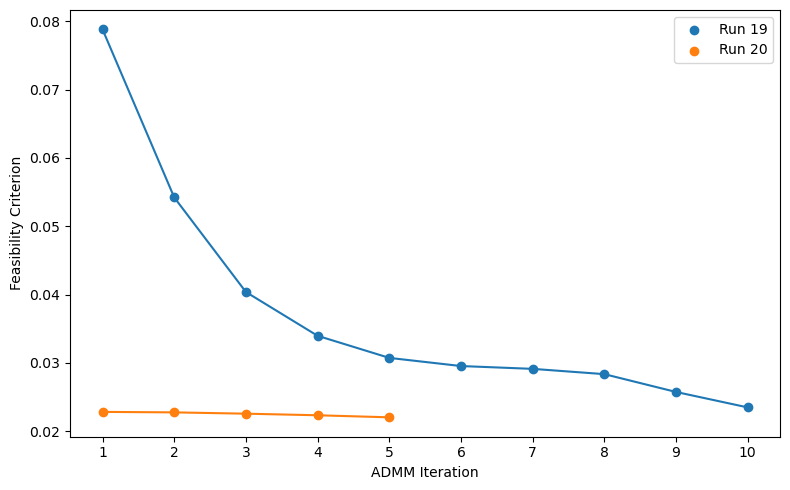

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, NUM_ITERS_19 + 1), feasibility_19)
plt.plot(np.arange(1, NUM_ITERS + 1), feasibility)
plt.scatter(np.arange(1, NUM_ITERS_19 + 1), feasibility_19, label='Run 19')
plt.scatter(np.arange(1, NUM_ITERS + 1), feasibility, label='Run 20')

plt.xticks(ticks=np.arange(1, NUM_ITERS_19 + 1), labels=np.arange(1, NUM_ITERS_19 + 1))
# plt.yscale('log')
# plt.ylim(0.02, 0.025)
plt.xlabel('ADMM Iteration')
plt.ylabel('Feasibility Criterion')
plt.legend()
plt.tight_layout()
# plt.savefig(SAVE_FIG_BASE + '/feasibility_progress.png', dpi=300)
plt.show()

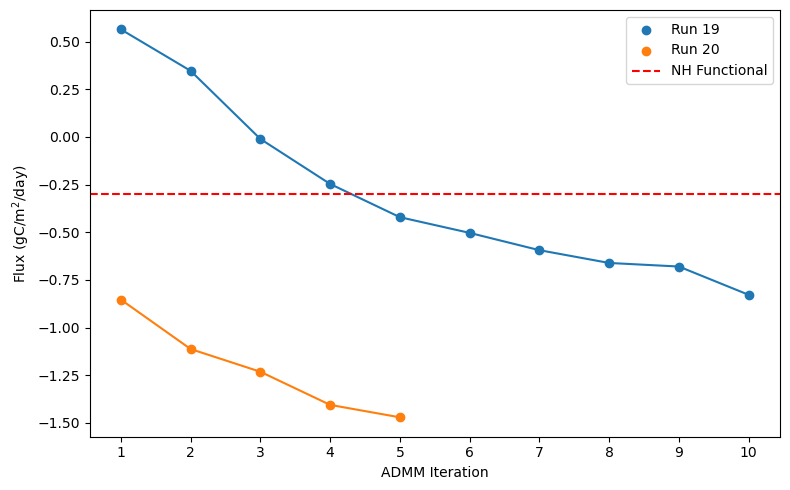

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, NUM_ITERS_19 + 1), final_res_19['objective_evals'])
plt.plot(np.arange(1, NUM_ITERS + 1), final_func_vals)
plt.scatter(np.arange(1, NUM_ITERS_19 + 1), final_res_19['objective_evals'], label='Run 19')
plt.scatter(np.arange(1, NUM_ITERS + 1), final_func_vals, label='Run 20')
plt.axhline(true_func_val, linestyle='--', label='NH Functional', color='red')

plt.xticks(ticks=np.arange(1, NUM_ITERS_19 + 1), labels=np.arange(1, NUM_ITERS_19 + 1))
# plt.ylim(-1, 1)
plt.xlabel('ADMM Iteration')
plt.ylabel('Flux (gC/m$^2$/day)')
plt.legend()
plt.tight_layout()
# plt.savefig(SAVE_FIG_BASE + '/endpoint_progress.png', dpi=300)
plt.show()

# Weight plots

In [35]:
# read in the starting w used
with open('./data/carbon_flux/results/20/intermediate_starts/w_start_it0.npy', 'rb') as f:
    w_start = np.load(file=f)

In [36]:
# add columns to the gosat dataframe
gosat_df['w_start'] = w_start

LAST_IDX = 4
for i in range(LAST_IDX):
    
    # weights
    gosat_df[f'w_admm{i}'] = final_res['w_opt_vecs'][i]
    
    # w y prods
    gosat_df[f'w_y_prods{i}'] = gosat_df[f'w_admm{i}'] * y_tilde

In [37]:
# create a datetime column for the observations
gosat_df['time'] = gosat_df.apply(
    lambda x: pd.to_datetime(f"{int(x['day'])}/{int(x['month'])}/{int(x['year'])}", format="%d/%m/%Y"),
    axis=1
)

# set the above as the index
gosat_df.set_index('time', inplace=True)

In [38]:
# define a color scheme
norm_start = mcolors.Normalize(
    vmin=gosat_df['w_start'].min(),
    vmax=gosat_df['w_start'].max(),
)
norm = mcolors.Normalize(
    vmin=gosat_df[['w_start', 'w_admm0']].values.flatten().min(),
    vmax=gosat_df[['w_start', 'w_admm0']].values.flatten().max(),
)

In [39]:
SAVE_FIG_BASE

'../figures/interval_optimizations/northern_hemisphere_jun2010/dual/20'

KeyError: 'w_admm4'

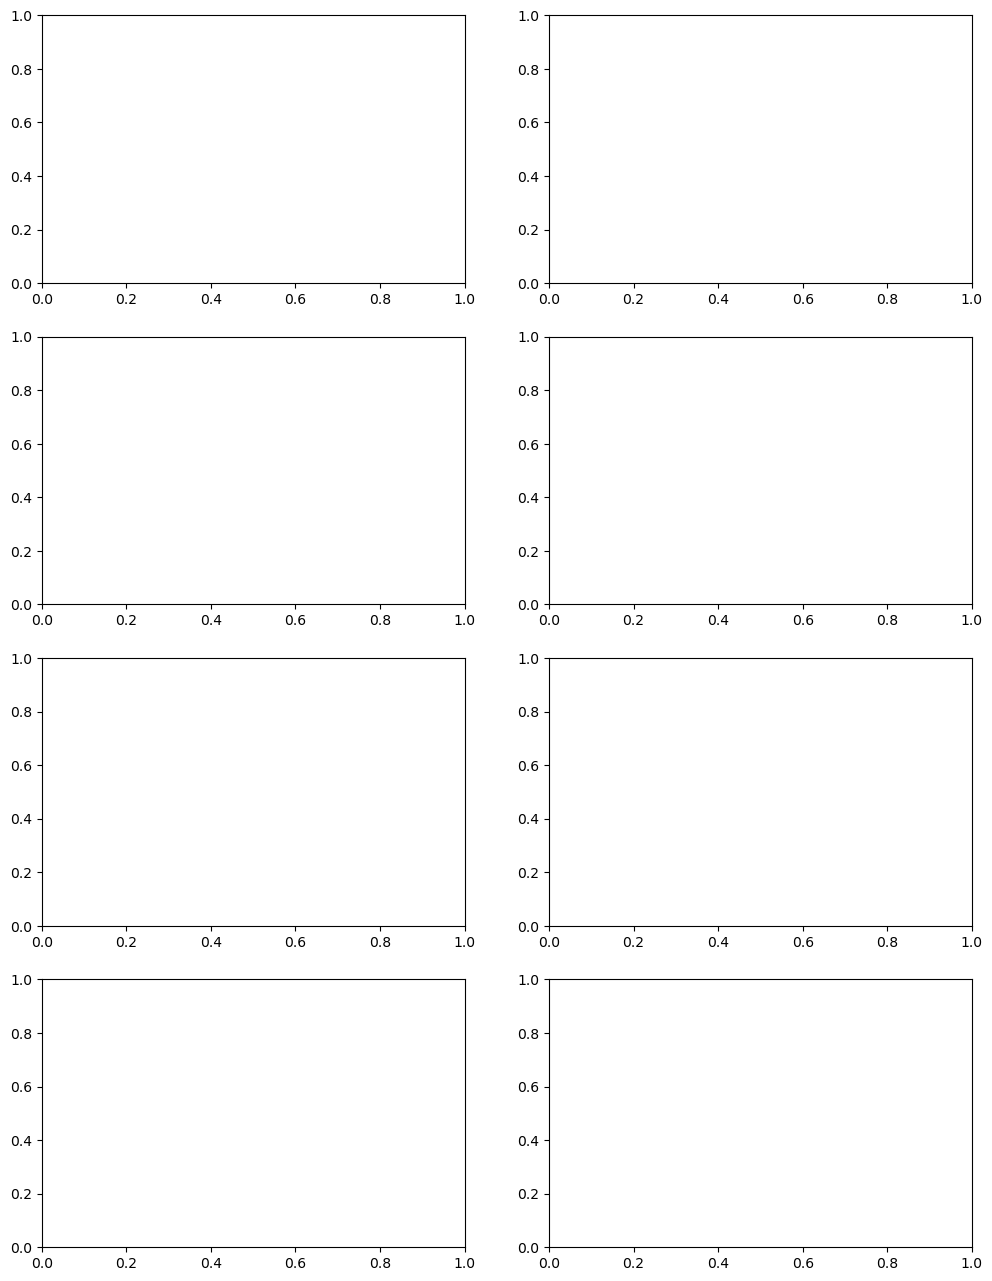

In [40]:
# after current ADMM iterations
for i in range(10):
    SAVE_FP = SAVE_FIG_BASE + '/w_admm%s.png' % str(i).zfill(2)
    month_map_plot(
        df=gosat_df, w_col_str=f'w_admm{i}', norm=None, vmin=-0.01, vmax=0.01,
        save_fp=SAVE_FP
    )

# Starting positions

Generated from run 19.

In [29]:
SAVE_BASE = '/Users/mikestanley/Research/Carbon_Flux/optimization/src_admm'
SAVE_BASE += '/data/carbon_flux/results/20/intermediate_starts'

In [12]:
# read in results from 19
with open(BASE_DIR + '/19/final_results.pkl', 'rb') as f:
    final_res_19 = pickle.load(f)

In [13]:
# saving w starting position
with open(SAVE_BASE + '/w_start_it0.npy', 'wb') as f:
    np.save(file=f, arr=final_res_19['w_opt_output']['vectors'][-1])
    
# saving c starting position
with open(SAVE_BASE + '/c_start_it0.npy', 'wb') as f:
    np.save(file=f, arr=final_res_19['c_opt_output']['vectors'][-1])
    
# saving lambda starting position
with open(SAVE_BASE + '/lambda_start_it0.npy', 'wb') as f:
    np.save(file=f, arr=final_res_19['lambda_opt_output']['vectors'][-1])

#### Starting positions after it1

In [ ]:
# saving w starting position
with open(SAVE_BASE + '/w_start_it0.npy', 'wb') as f:
    np.save(file=f, arr=final_res_19['w_opt_output']['vectors'][-1])
    
# saving c starting position
with open(SAVE_BASE + '/c_start_it0.npy', 'wb') as f:
    np.save(file=f, arr=final_res_19['c_opt_output']['vectors'][-1])
    
# saving lambda starting position
with open(SAVE_BASE + '/lambda_start_it0.npy', 'wb') as f:
    np.save(file=f, arr=final_res_19['lambda_opt_output']['vectors'][-1])

#### Starting positions after iteration 2

In [40]:
# saving w starting position
with open(SAVE_BASE + '/w_start_it2.npy', 'wb') as f:
    np.save(file=f, arr=final_res['w_opt_vecs'][2])
    
# saving c starting position
with open(SAVE_BASE + '/c_start_it2.npy', 'wb') as f:
    np.save(file=f, arr=final_res['c_opt_vecs'][2])
    
# saving lambda starting position
with open(SAVE_BASE + '/lambda_start_it2.npy', 'wb') as f:
    np.save(file=f, arr=final_res['lambda_opt_vecs'][2])

#### Starting position after iteration 4

In [30]:
# saving w starting position
with open(SAVE_BASE + '/w_start_it4.npy', 'wb') as f:
    np.save(file=f, arr=final_res['w_opt_vecs'][4])
    
# saving c starting position
with open(SAVE_BASE + '/c_start_it4.npy', 'wb') as f:
    np.save(file=f, arr=final_res['c_opt_vecs'][4])
    
# saving lambda starting position
with open(SAVE_BASE + '/lambda_start_it4.npy', 'wb') as f:
    np.save(file=f, arr=final_res['lambda_opt_vecs'][4])